# Jaxified ELR model for gravity darkening on a rapidly rotating star:

In this notebook, I will show a particular model for generating a 3d rendering of a rapidly rotating star--the Espinosa Lara and Rieutord (2011) model. First, I will show an unvectorized version taken from [Gdit package](https://github.com/aarondotter/GDit/blob/master/GDit.py). Then, I will show my vectorized and autodiff-able model written in Jax, which should be much faster, especially for inference. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root

import colorpy
from colorpy import colormodels
from colorpy import blackbody

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Unvectorized ELR Model:
Here is the unvectorized ELR model solver (taken from [Gdit package](https://github.com/aarondotter/GDit/blob/master/GDit.py)):

It takes a latitude angle $\theta$ and a rotation rate $\omega$ from 0-1 (1 being the critical rotation rate a.k.a breakup velocuty) and returns three parameters: the radius from the center of the star at that latitude, the flux and temperature as a fraction of the flux and temperature at the pole. 

In [2]:
#constants
G=6.67428e-8
sigma=5.67040e-5
f23=2.0/3.0
Lsun=3.8418e33
Msun=1.989e33
Rsun=6.96e10

#ELR11 equations
#gives the value of phi
def eq24(phi,theta,omega,rtw):
    tau = (pow(omega,2) * pow(rtw*np.cos(theta),3) )/3.0 + np.cos(theta) + np.log(np.tan(0.5*theta))
    return np.cos(phi) + np.log(np.tan(0.5*phi)) - tau

#solve for rtw given omega
def eq30(rtw,theta,omega):
    w2=omega*omega
    return (1./w2)*(1./rtw - 1.0) + 0.5*(pow(rtw*np.sin(theta),2) - 1.0)



def solve_ELR(omega,theta): #eq.26, 27, 28; solve the ELR11 equations
    """calculates r~, Teff_ratio, and Flux_ratio"""
    #theta is the polar angle.
    #this routine calculates values for 0 <= theta <= pi/2
    #everything else is mapped into this interval by symmetry
    # theta = 0 at the pole(s)
    # theta = pi/2 at the equator
    # -pi/2 < theta < 0: theta -> abs(theta)
    #  pi/2 > theta > pi: theta -> pi - theta
    if np.pi/2 < theta <= np.pi:
        theta = np.pi - theta
    if -np.pi/2 <= theta < 0:
        theta = abs(theta)

    if omega==0.0: #common sense
        return np.ones(3)
    
    else:
        #first we solve equation 30 for rtw
        q = root(fun=eq30,args=(theta, omega), x0=1.0)
        rtw = q['x'].item()

        #the following are special solutions for extreme values of theta
        w2r3=pow(omega,2)*pow(rtw,3)
        
        if theta==0.0: #pole, eq. 27
            Fw = np.exp( f23 * w2r3 )

        elif theta==0.5*np.pi: #equator, eq. 28
            if omega < 1.0:
                Fw = pow(1.0 - w2r3, -f23)
            else:
                Fw = 0.0

        else: #general case for Fw
            q = root(fun=eq24,args=(theta, omega, rtw), x0=theta)
            phi = q['x'].item()
            
            Fw = pow(np.tan(phi)/np.tan(theta), 2)

        #equation 31 and similar for Fw
        term1 = pow(rtw,-4)
        term2 = pow(omega,4)*pow(rtw*np.sin(theta),2)
        term3 = -2*pow(omega*np.sin(theta),2)/rtw
        gterm = np.sqrt(term1+term2+term3)
        Flux_ratio = Fw*gterm
        Teff_ratio = pow(Flux_ratio,0.25)
        return rtw, Teff_ratio, Flux_ratio

Without vectorization, we can create an image of a star by iterating through each polar angle $\theta$ within a for loop.

In [3]:
thetas = np.linspace(0, np.pi/2,100)
omega = 0.9
rtws = []
Fs_unvec = []
Ts = []
for theta in thetas:
    rtw, T, F = solve_ELR(omega, theta)
    rtws.append(rtw)
    Fs_unvec.append(F)
    Ts.append(T)

In [4]:
RTWs = np.array(rtws)
Fs = np.array(Fs_unvec)
Fmin=Fs.min()
Fmax=Fs.max()
Fs = (Fs)/(Fmax)

irgbs = []
for T in Ts:
    xyz = blackbody.blackbody_color(np.rint(T*7700))
    irgbs.append(colormodels.irgb_from_xyz(xyz))

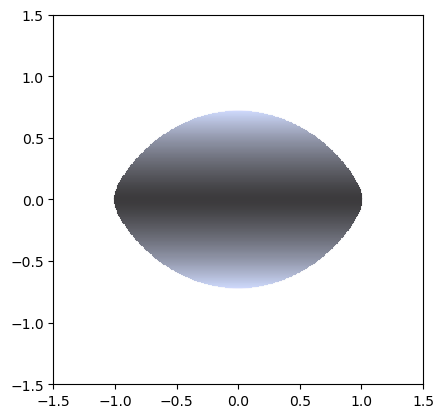

In [5]:
colors = np.array(irgbs)/255
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')
for F, rtw, color, theta in zip(Fs, RTWs, colors, thetas):
    plt.plot([-rtw*np.sin(theta),rtw*np.sin(theta)], [rtw*np.cos(theta), rtw*np.cos(theta)], c=color*F)
    plt.plot([-rtw*np.sin(theta),rtw*np.sin(theta)], [-rtw*np.cos(theta), -rtw*np.cos(theta)], c=color*F)

Timing the above code:

In [6]:
%%timeit
thetas = np.linspace(0, np.pi/2,100)
omega = 0.9
rtws = []
Fs_unvec = []
Ts = []
for theta in thetas:
    rtw, T, F = solve_ELR(omega, theta)
    rtws.append(rtw)
    Fs_unvec.append(F)
    Ts.append(T)

12 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Vectorized ELR model in jax:

Here, I code the above model in jax. The code above is unvectorized as it uses an unvectorized scipy root finder to solve the differential equations in the ELR 2011 paper. I instead use an implementation of a solver in the jaxopt package. To ensure numerical stability, I set the tolerance to 1e-14 and force the use of 64 bit floats. 

In [65]:
import jax
import jax.numpy as jnp
from jaxopt import Bisection
import matplotlib.pyplot as plt
from jax.lax import cond
from jax.config import config
config.update("jax_enable_x64", True)

"""
Provide a vectorized and jaxed version of the ELR model for speed
"""
#constants
G=6.67428e-8
sigma=5.67040e-5
f23=2.0/3.0
Lsun=3.8418e33
Msun=1.989e33
Rsun=6.96e10

#ELR11 equations
#gives the value of phi
def eq24_jax(phi,theta,omega,rtw):
    tau = (jnp.power(omega,2) * jnp.power(rtw*jnp.cos(theta),3) )/3.0 + jnp.cos(theta) + jnp.log(jnp.tan(0.5*theta))
    return jnp.cos(phi) + jnp.log(jnp.tan(0.5*phi)) - tau

#solve for rtw given omega
def eq30_jax(rtw,theta,omega):
    #jaxed and vectorized
    return (1./omega**2)*(1./rtw - 1.0) + 0.5*((rtw*jnp.sin(theta))**2 - 1.0)


def solve_ELR_jax(omega, theta): #eq.26, 27, 28; solve the ELR11 equations
    """
    
    Takes a float omega where 0<=omega<1
    and a single value theta, or polar angles in radians
    
    calculates r~, Teff_ratio, and Flux_ratio
    
    Can be vmapped to solve for an array of thetas (done below)

    """
    #theta is the polar angle.
    #this routine calculates values for 0 <= theta <= pi/2
    #everything else is mapped into this interval by symmetry
    # theta = 0 at the pole(s)
    # theta = pi/2 at the equator
    # -pi/2 < theta < 0: theta -> abs(theta)
    #  pi/2 > theta > pi: theta -> pi - theta
    theta = jnp.where(
            jnp.logical_and(theta>jnp.pi/2, theta<=jnp.pi), #if
            jnp.pi - theta, #then
            theta #else
            ) 
            
    theta = jnp.where(
            jnp.logical_and(theta>=-jnp.pi/2, theta<0),
            jnp.abs(theta),
            theta
        )

    #first we solve equation 30 for rtw
    q = Bisection(optimality_fun=eq30_jax, lower=0,upper=1,check_bracket=False,tol=1e-14,maxiter=101)
    rtw = q.run(jnp.ones_like(theta), **{"theta":theta, "omega":omega}).params
    #the following are special solutions for extreme values of theta
    w2r3=omega**2*rtw**3
    q = Bisection(optimality_fun=eq24_jax, lower=0+1e-10,upper=jnp.pi/2-1e-10,check_bracket=False,tol=1e-14,maxiter=101) 
    Fw = jnp.where(
            theta==0, #if
            jnp.exp( f23 * w2r3 ), #then
            
            jnp.where( 
                    theta==0.5*jnp.pi, #elsif
                    (1.0 - w2r3)**(-f23), #then
                    
                    #very cumbersome way of computing the else case without a cond, see the unvectorized version for clarity
                    (jnp.tan(q.run(theta, **{"theta":theta, "omega":omega, "rtw":rtw}).params) / jnp.tan(theta))**2
                                    )
                           )
    #equation 31 and similar for Fw
    term1 = rtw**(-4)
    term2 = omega**4*(rtw*jnp.sin(theta))**2
    term3 = -2*(omega*jnp.sin(theta))**2/rtw
    gterm = jnp.sqrt(term1+term2+term3)
    Flux_ratio = Fw*gterm
    Teff_ratio = Flux_ratio**0.25
    return rtw, Teff_ratio, Flux_ratio


solve_ELR_vec = jax.jit(jax.vmap(solve_ELR_jax, in_axes=[None,0]))

Instead of iterating through polar angle $\theta$ to render a full star map, I can use a linspace of angles:

In [96]:
thetas = jnp.linspace(0+1e-10, jnp.pi/2-0.001,201)
omega = 0.5
rtws, Ts, Fs = solve_ELR_vec(omega, thetas)

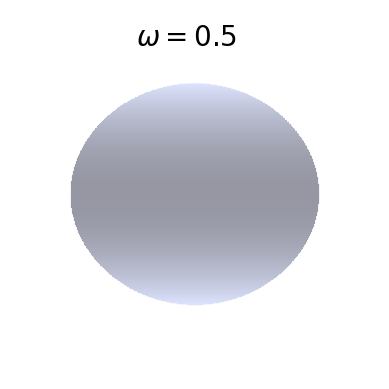

In [99]:
Fmin=Fs.min()
Fmax=Fs.max()
Fs = (Fs)/(Fmax)

irgbs = []
for T in Ts:
    xyz = blackbody.blackbody_color(np.rint(T*7700))
    irgbs.append(colormodels.irgb_from_xyz(xyz))

colors = np.array(irgbs)/255.0

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')
for F, rtw, color, theta in zip(Fs, rtws, colors, thetas):
    plt.plot([-rtw*np.sin(theta),rtw*np.sin(theta)], [rtw*np.cos(theta), rtw*np.cos(theta)], c=color*F.item())
    plt.plot([-rtw*np.sin(theta),rtw*np.sin(theta)], [-rtw*np.cos(theta), -rtw*np.cos(theta)], c=color*F.item())
    
plt.axis('off')
plt.suptitle(r"$\omega=0.5$", y=0.85, fontsize=20)
plt.savefig('oblate_50.pdf')

Now, timing the vectorized and jaxed code, we can see that it is about 50 times faster than the unvectorized version:

In [14]:
%%timeit
thetas = jnp.linspace(0.0, jnp.pi/2,100)
omega = 0.9
rtws, Ts, Fs = solve_ELR_vec(omega, thetas)

233 µs ± 624 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
